In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from imblearn import under_sampling, over_sampling
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from collections import Counter
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, cross_validate
import pytz
from datetime import datetime
import statsmodels.api as sm

# **1. Preprocessing:**

### **1.1 Meteo data:**

In [ ]:
# dowloading meteo_data from drive
!gdown 1Ohd1RtQfd5VvwQutR73j0UvIDNrG7SPk
!gdown 1omuJswIXB2-eo5Cp82s09AkqLOksmvdu
!gdown 1lnRxlo9X1efzltjApivBT_Cq4JWoTHQx
!gdown 1dMmdBqVrMbuHjlMOguQdv7S6F5_N73Ih
!gdown 18-t9HQabz0pSbr6u6Eyilj3tUg0QJwfb

Downloading...
From: https://drive.google.com/uc?id=1Ohd1RtQfd5VvwQutR73j0UvIDNrG7SPk
To: /content/LC_2022Q1.csv
100% 147M/147M [00:00<00:00, 235MB/s]
Downloading...
From: https://drive.google.com/uc?id=1omuJswIXB2-eo5Cp82s09AkqLOksmvdu
To: /content/LC_2022Q2.csv
100% 167M/167M [00:01<00:00, 147MB/s]
Downloading...
From: https://drive.google.com/uc?id=1lnRxlo9X1efzltjApivBT_Cq4JWoTHQx
To: /content/LC_2022Q3.csv
100% 174M/174M [00:01<00:00, 128MB/s]
Downloading...
From: https://drive.google.com/uc?id=1dMmdBqVrMbuHjlMOguQdv7S6F5_N73Ih
To: /content/LC_2022Q4.csv
100% 160M/160M [00:00<00:00, 228MB/s]
Downloading...
From: https://drive.google.com/uc?id=18-t9HQabz0pSbr6u6Eyilj3tUg0QJwfb
To: /content/Meteo_Stations.csv
100% 7.57k/7.57k [00:00<00:00, 25.6MB/s]


In [ ]:
# reading meteo_data files
meteo1 = pd.read_csv('/content/LC_2022Q1.csv', sep=',')
meteo2 = pd.read_csv('/content/LC_2022Q2.csv', sep=',')
meteo3 = pd.read_csv('/content/LC_2022Q3.csv', sep=',')
meteo4 = pd.read_csv('/content/LC_2022Q4.csv', sep=',')
stations = pd.read_csv('/content/Meteo_Stations.csv',sep=',')

In [ ]:
# merge meteo1,2,3 and 4 into one frame
dfs = [meteo1, meteo2, meteo3, meteo4]
meteo = pd.concat(dfs)

#### **A. Filter out the station in the city center:**
The meteo data contains many stations in the district of Leuven. Since our objective is to study noise in the center of Leuven we restrict ourself to the data from the stations in the city center and average them to obtain one weather data set. <br>
**Note:** The variables WINDDIR and WINDSPEED need a more 'local' approach. We do not average them over all stations in the city center but we average them over all stations in the close proximity of Naamsestraat.

In [ ]:
# make a list of all station in city center and around Naamsestraat
center_stationsID = list()
naamsestraat_stationsID = list()
(x0,y0) = (50.87959, 4.70093) # city center
(x1,y1) = (50.876356, 4.700403) # midpoint of Filosofia - Grote Markt
for i in range(0,len(stations['ID'])):
    LAT = stations['LAT'][i]
    LON = stations['LON'][i]
    if ((LAT-x0)**2 + (LON-y0)**2 <= (0.02)**2):
        center_stationsID.append(stations['ID'][i])
    if ((LAT-x1)**2 + (LON-y1)**2 <= (0.003939)**2):
        naamsestraat_stationsID.append(stations['ID'][i])

# we make a new dataset with only the observations from the city stations and Naamsestraat stations
meteo_center = meteo.loc[meteo['ID'].isin(center_stationsID)]
meteo_center = meteo_center.drop(["LC_WINDDIR", "LC_WINDSPEED"], axis=1)
meteo_naamse = meteo.loc[meteo['ID'].isin(naamsestraat_stationsID), ["ID","DATEUTC", "LC_WINDDIR", "LC_WINDSPEED"]]
#reset labelling
meteo_center = meteo_center.reset_index(drop=True)
meteo_naamse = meteo_naamse.reset_index(drop=True)

#### **B. Merge last 4 columns into 1 TEMP column by averaging:**

In [ ]:
df = meteo_center.iloc[:,-4:]
meteo_center['AV_TEMP'] = df.mean(axis=1) 

#### **C. Merge measurements of all stations together by averaging over all stations:**

In [ ]:
# we select the columns that need to be averaged over the different stations: 
df1 = meteo_center[['DATEUTC', 'LC_HUMIDITY', 'LC_DWPTEMP', 'LC_RAD', 'LC_RAININ', 'LC_DAILYRAIN', 'LC_RAD60', 'AV_TEMP']]
df2 = meteo_naamse[['DATEUTC', 'LC_WINDDIR', 'LC_WINDSPEED']]
# groups the data on DATEUTC, this column repeats itself 50 times for center_stations and 8 times for Naamsestraat stations.
df1_perDATEUTC = df1.groupby(['DATEUTC'], as_index = False)
df2_perDATEUTC = df2.groupby(['DATEUTC'], as_index = False)
# Average over stations
average_weather = df1_perDATEUTC.mean()
average_WIND = df2_perDATEUTC.mean()

# Merge all columns back together
average_meteo = pd.merge(average_weather,average_WIND, on='DATEUTC')

#### **D. Set meteo data DATEUTC from UTC+0 to time in leuven (according to seasons!):**

In [ ]:
# First we change elements of DATEUTC to a datetime objects
average_meteo['DATEUTC'] = pd.to_datetime(average_meteo['DATEUTC'], format = '%Y-%m-%d %H:%M:%S')
# Set the original time zone as UTC
original_timezone = pytz.timezone('UTC')
# Convert the time zone to UTC+1
target_timezone = pytz.timezone('Europe/Brussels')
# Convert dataset from UTC+0 to UTC+1
average_meteo['DATEUTC'] = average_meteo['DATEUTC'].dt.tz_localize(original_timezone).dt.tz_convert(target_timezone)

In [ ]:
# the final 'cleaned' data set
average_meteo.head()

,DATEUTC,LC_HUMIDITY,LC_DWPTEMP,LC_RAD,LC_RAININ,LC_DAILYRAIN,LC_RAD60,AV_TEMP,LC_WINDDIR,LC_WINDSPEED
0,2022-01-01 01:10:00+01:00,89.916667,11.476667,0.166667,0.0,0.0,0.166667,13.048609,17.500,0.04375
1,2022-01-01 01:20:00+01:00,89.666667,11.416042,0.166667,0.0,0.0,0.166667,13.046635,42.125,0.04000
2,2022-01-01 01:30:00+01:00,89.458333,11.409375,0.145833,0.0,0.0,0.145833,13.067383,-0.875,0.06125
3,2022-01-01 01:40:00+01:00,89.229167,11.400000,0.166667,0.0,0.0,0.166667,13.099382,6.375,0.04500
4,2022-01-01 01:50:00+01:00,89.000000,11.394167,0.166667,0.0,0.0,0.166667,13.123046,-10.125,0.02500


### **1.2 Export41 data:**

In [ ]:
# downloading export41 data from drive
!gdown https://drive.google.com/drive/folders/15prWrulNe0HMDbF-27YSUPmpU-FIcS-N -O /content/ --folder
!gdown https://drive.google.com/drive/folders/1k88urhr6Rhfeavtn5nbfShlpCVu3lGDh -O /content/ --folder
!gdown https://drive.google.com/drive/folders/15prWrulNe0HMDbF-27YSUPmpU-FIcS-N -O /content/ --folder
!gdown https://drive.google.com/drive/folders/1k88urhr6Rhfeavtn5nbfShlpCVu3lGDh -O /content/ --folder

Retrieving folder list
Processing file 1Xyrm56s3GdCRQ5iekA46O-fVKaaHgIZE csv_results_40_255439_mp-01-naamsestraat-35-maxim.csv
Processing file 1sRot8QgirKzTAdKPWP7qbvDEQ4sByAI- csv_results_40_255440_mp-02-naamsestraat-57-xior.csv
Processing file 14uZmVvoXu7dDuODCoydxf10sGwk21wBY csv_results_40_255441_mp-03-naamsestraat-62-taste.csv
Processing file 1XqOb1M8JI7-LDT3qrAHe4EOHfP7HNYts csv_results_40_255442_mp-05-calvariekapel-ku-leuven.csv
Processing file 1TT2fK8wnXh5OkmgpG9t5M8ODmYuOvv0s csv_results_40_255443_mp-06-parkstraat-2-la-filosovia.csv
Processing file 1K8FYGfLJ-_iqp8oWXf-3pAEmjgDbRALT csv_results_40_255444_mp-07-naamsestraat-81.csv
Processing file 1_m7kRCrZ8xSWFFhN7J9FeD2_N1nzMvBV csv_results_40_255445_mp-08-kiosk-stadspark.csv
Processing file 1V7FkWcPD5UqUU8bXvYPQXp5tQv1hRGS_ csv_results_40_280324_mp08bis---vrijthof.csv
Processing file 1fc-q7TR7l1GoY3EbeSlYtx_ivc5QigCv csv_results_40_303910_mp-04-his-hears.csv
Retrieving folder list completed
Building directory structure
Buildin

In [ ]:
# reading export_41 data files
event_1 = pd.read_csv('/content/export_41/csv_results_41_280324_mp08bis---vrijthof.csv', sep=';')
event_2 = pd.read_csv('/content/export_41/csv_results_41_255439_mp-01-naamsestraat-35-maxim.csv', sep=';')
event_3 = pd.read_csv('/content/export_41/csv_results_41_255440_mp-02-naamsestraat-57-xior.csv', sep=';')
event_4 = pd.read_csv('/content/export_41/csv_results_41_255441_mp-03-naamsestraat-62-taste.csv', sep=';')
event_5 = pd.read_csv('/content/export_41/csv_results_41_303910_mp-04-his-hears.csv', sep=';')
event_6 = pd.read_csv('/content/export_41/csv_results_41_255445_mp-08-kiosk-stadspark.csv', sep=';')
event_7 = pd.read_csv('/content/export_41/csv_results_41_255442_mp-05-calvariekapel-ku-leuven.csv', sep=';')
event_8 = pd.read_csv('/content/export_41/csv_results_41_255443_mp-06-parkstraat-2-la-filosovia.csv', sep=';')
event_9 = pd.read_csv('/content/export_41/csv_results_41_255444_mp-07-naamsestraat-81.csv', sep=';')

# Note: locations 5 and 6 are completely empty, there was no noise detected or the device was defect!
frames = [event_1, event_2, event_3, event_4, event_7, event_8, event_9] ;
export41_concat = pd.concat(frames);

# Note: we ordered the locations according to distance from the Oude Markt! (starting from closest) 

In [ ]:
# 1. Drop some irrelevant columns
export41 = export41_concat.drop(columns=['#object_id', 'noise_event_laeq_model_id', 'noise_event_laeq_model_id_unit', 'noise_event_laeq_primary_detected_certainty_unit', 'noise_event_laeq_primary_detected_class_unit'])

# Some justification:
# '#object_id' --> it is sufficient if we keep the column 'description'
# 'noise_event_laeq_model_id' --> is not empty but has no clear interpretation...

# 2. Drop observations that have 2 or more NaN values
export41 = export41.dropna(thresh = 3, axis = 0)

# 3. Drop all noise events that were recorded with 0% certainty
export41 = export41[export41["noise_event_laeq_primary_detected_certainty"] != 0].reset_index(drop=True)

In [ ]:
# 4. Make column 'result_timestamp' a datetime-object
export41['result_timestamp'] = pd.to_datetime(export41['result_timestamp'], format = '%d/%m/%Y %H:%M:%S.%f')
export41['result_timestamp'] = export41['result_timestamp'].dt.tz_localize(pytz.timezone('Europe/Brussels')) # set timezone
# round times to 10minutes, this way we can match it with the meteodata
export41['result_timestamp'] = export41['result_timestamp'].dt.round('10min') 
# check
export41.head()

,description,result_timestamp,noise_event_laeq_primary_detected_certainty,noise_event_laeq_primary_detected_class
0,MP08bis - Vrijthof,2022-04-20 12:30:00+02:00,100.0,Transport road - Passenger car
1,MP08bis - Vrijthof,2022-04-24 21:10:00+02:00,100.0,Nature elements - Wind
2,MP08bis - Vrijthof,2022-04-24 21:10:00+02:00,100.0,Nature elements - Wind
3,MP08bis - Vrijthof,2022-05-09 13:20:00+02:00,100.0,Transport road - Siren
4,MP08bis - Vrijthof,2022-05-10 03:40:00+02:00,100.0,Transport road - Siren


### **1.3 Traffic Data:**

In [ ]:
import requests
import json

# Read traffic data from the telraam API 
url = "https://telraam-api.net/v1/reports/traffic"
# extract traffic data period: 1jan - 1april 2022
body = {
    "id":"9000000637",
    "time_start":"2021-12-31 23:00:00Z",
    "time_end":"2022-04-01 23:50:00Z",
    "level":"segments",
    "format":"per-hour"
}
headers = {
  'X-Api-Key': '30dUHC5xmy8m66g5efjhg6F1MnBA7IVQwXfOUfse'
}
payload = str(body)
response = requests.request("POST", url, headers=headers, data=payload)
json = response.json()
df1 = pd.DataFrame(json['report'])

# extract traffic data period: 2april-1july 2022
body = {
    "id":"9000000637",
    "time_start":"2022-04-02 00:00:00Z",
    "time_end":"2022-07-01 23:50:00Z",
    "level":"segments",
    "format":"per-hour"
}
headers = {
  'X-Api-Key': '30dUHC5xmy8m66g5efjhg6F1MnBA7IVQwXfOUfse'
}
payload = str(body)
response = requests.request("POST", url, headers=headers, data=payload)
json = response.json()
df2 = pd.DataFrame(json['report'])

# extract traffic data period: 2july - 1oct 2022
body = {
    "id":"9000000637",
    "time_start":"2022-07-02 00:00:00Z",
    "time_end":"2022-10-01 23:50:00Z",
    "level":"segments",
    "format":"per-hour"
}
headers = {
  'X-Api-Key': '30dUHC5xmy8m66g5efjhg6F1MnBA7IVQwXfOUfse'
}
payload = str(body)
response = requests.request("POST", url, headers=headers, data=payload)
json = response.json()
df3 = pd.DataFrame(json['report'])

# extract traffic data period: 2oct - 31dec 2022
body = {
    "id":"9000000637",
    "time_start":"2022-10-02 00:00:00Z",
    "time_end":"2022-12-31 23:50:00Z",
    "level":"segments",
    "format":"per-hour"
}
headers = {
  'X-Api-Key': '30dUHC5xmy8m66g5efjhg6F1MnBA7IVQwXfOUfse'
}
payload = str(body)
response = requests.request("POST", url, headers=headers, data=payload)
json = response.json()
df4 = pd.DataFrame(json['report'])

# merge the four time periods together to obtain final traffic data
traffic = pd.concat([df1, df2, df3, df4]).reset_index(drop=True)

In [ ]:
# select the relevant variables
traffic = traffic[['date', 'heavy', 'car', 'bike', 'pedestrian']]
traffic.head()

,date,heavy,car,bike,pedestrian
0,2021-12-31T23:00:00.000Z,0.0,0.0,0.0,0.0
1,2022-01-01T00:00:00.000Z,0.0,0.0,0.0,0.0
2,2022-01-01T01:00:00.000Z,0.0,0.0,0.0,0.0
3,2022-01-01T02:00:00.000Z,0.0,0.0,0.0,0.0
4,2022-01-01T03:00:00.000Z,0.0,0.0,0.0,0.0


In [ ]:
# Make column 'date' a datetime-object
traffic['date'] = pd.to_datetime(traffic['date'], format="%Y-%m-%d %H:%M:%S")

### **A. Problem with Missing Values:** 
The data from Telraam at Naamsestraat (segment:9000000637) was only measured between 8:00 and 15:00 and sometimes also at 7:00. All data outside this interval was measured as 0.0, meaning that we have no traffic data during night time. We try imputation methods to fill in as many of the zero values. 

In [ ]:
## 1. Observations from 15:00 can be caried forward one more hour, so untill 16:00

traffic['date'] = pd.to_datetime(traffic['date'])
col_15 = traffic[traffic['date'].dt.hour == 15].drop("date", axis=1) # get observations from 15:00
col_15.index = col_15.index + 1 # up there index so that it matches observations from 16:00
date_16 = traffic.loc[traffic['date'].dt.hour == 16,"date"].to_frame(name='date')
merged = date_16.join(col_15)
# change observations from 16:00 in original dataset to the new ones from "merged"
traffic.loc[merged.index] = merged

In [ ]:
## 2. Set empty observation from 7:00 to average of 7:00

average_7 = traffic[traffic['date'].dt.hour == 7].drop("date", axis=1).mean(axis=0)
#get all observations from 7:00
obs_at_7 = traffic[traffic['date'].dt.hour == 7].drop("date",axis=1) 
# select the ones that are zero in all 4 columns
num_zero = obs_at_7.eq(0).sum(axis=1)
zeros_7 = obs_at_7[num_zero == 4]
zeros_7_idx = zeros_7.index 

# make dataframe with only average_7
average_7_df = pd.DataFrame(np.tile(average_7, (len(zeros_7), 1)))
# change index to match with index from the to be changed observations
average_7_df.index = zeros_7_idx
# change colnames
average_7_df.columns = obs_at_7.columns
# add 'date' column
average_7_df = pd.DataFrame(traffic.loc[zeros_7_idx]["date"]).join(average_7_df)
# change 7:00 observations in traffic dataset
traffic.loc[average_7_df.index] = average_7_df

# **2. Modelfitting:**



We fit a machine learning algorithm trained on export41 (noise event class), meteo data (date, weather conditions...) and traffic data (number of pedestrians, cars,...) that can predict for a new observation (date/time, weather conditions...) what the probability is for all noise events. <br> **Approach:** We fit three different classifiers (Naive Bayes, Decision tree and Random Forest) afterwards we compare their score on a test set to choose the best one. 

In [ ]:
## PREPROCESSING ##
# 1. Merge export41, average_meteo and traffic together based on time from export41
export41.rename(columns={'result_timestamp': 'DATEUTC', 'noise_event_laeq_primary_detected_certainty' : 'certainty', 
                         'noise_event_laeq_primary_detected_class' : 'noise_event' }, inplace=True)
traffic.rename(columns={'date': 'DATEUTC'}, inplace=True)
almost_merged = pd.merge(average_meteo,export41, on='DATEUTC')
merged = pd.merge(almost_merged, traffic, on = "DATEUTC")
# Make column 'DATEUTC' a datetime-object
merged['DATEUTC'] = pd.to_datetime(merged['DATEUTC'], format="%Y-%m-%d %H:%M:%S")

In [ ]:
merged.head()

,DATEUTC,LC_HUMIDITY,LC_DWPTEMP,LC_RAD,LC_RAININ,LC_DAILYRAIN,LC_RAD60,AV_TEMP,LC_WINDDIR,LC_WINDSPEED,description,certainty,noise_event,heavy,car,bike,pedestrian
0,2022-01-07 17:00:00+01:00,92.250000,1.642917,0.125000,0.000021,0.004667,8.645833,2.753157,-10.571429,0.081429,MP 03: Naamsestraat 62 Taste,100.0,Transport road - Passenger car,20.729367,122.994242,172.744722,120.230326
1,2022-01-09 22:00:00+01:00,93.954545,0.514545,0.090909,0.000000,0.005909,0.086957,1.369592,-9.428571,0.000000,MP 03: Naamsestraat 62 Taste,99.0,Transport road - Passenger car,0.000000,0.000000,0.000000,0.000000
2,2022-01-10 11:00:00+01:00,97.723404,-0.529574,43.702128,0.000000,0.000021,29.638298,-0.248377,-40.142857,0.055714,MP 03: Naamsestraat 62 Taste,42.0,Human voice - Shouting,55.095652,101.426087,201.600000,87.652174
3,2022-01-11 09:00:00+01:00,92.553191,-0.800000,3.531915,0.000000,0.000000,0.085106,0.271255,35.285714,0.054286,MP 03: Naamsestraat 62 Taste,67.0,Transport road - Passenger car,71.043093,137.736609,194.281112,101.490133
4,2022-01-12 07:00:00+01:00,90.063830,0.456809,0.085106,0.000043,0.000000,0.085106,1.907448,-31.285714,0.017143,MP 03: Naamsestraat 62 Taste,29.0,Human voice - Shouting,0.000000,0.000000,0.000000,0.000000


In [ ]:
# 2. Create extra columns (hour, day, month, weekend, academic calender)

# Tim, Day, Month
merged['hour']=merged["DATEUTC"].dt.hour #dt.hour rounds down to the hour that we are in: for example 23:35:00 = 23.
merged['dayOfWeek']=merged["DATEUTC"].dt.dayofweek # 0 = Mon, 1 = Tues,... , 6 = Sun
merged['month']=merged["DATEUTC"].dt.month

# Include weekend (0/1) 
merged['weekend'] = 1 # create column that is 1 everywhere
merged.loc[merged['dayOfWeek'] <= 4, 'weekend'] = 0 #weekday=0, weekend=1

#Academic Calender: schoolyear=0, no class/exams=1
merged['day']=merged["DATEUTC"].dt.day # is necessary if we are going to specify academic calender, will later be deleted
merged['academic_calender'] = 0
merged.loc[merged['month'].isin([1,6,7,8,9]), 'academic_calender'] = 1 #jan, june, july, aug, sept
merged.loc[(merged['month'] == 12) & (merged['day'].isin(range(25,32,1))), 'academic_calender'] = 1 # last week of dec. (exams)
merged.loc[(merged['month'] == 2) & (merged['day'].isin(range(1,14,1))), 'academic_calender'] = 1 # first 2 weeks in feb. (exams + vacation)
merged.loc[(merged['month'] == 4) & (merged['day'].isin(range(4,18,1))), 'academic_calender'] = 1 # easter vacation

**Note:** When training a decision tree the input variables need to be numerical. Currently, variables such as hour, day and month are encoded in an acyclic way but in reality they are cyclical (december is close to january but the model now only sees 12 and 1 which are far away from each other). Hence we transform these variables into cyclical variables. 

In [ ]:
# 2.1 Make cyclic variabels for hour (0,1,...,23), month (1,..,12) and dayOfWeek (0,...,6). This can be done by introducing two coordinates (x=cos(.),y=sin(.)):
import math
from sklearn.preprocessing import MinMaxScaler

# We normalize 'hour', 'dayOfWeek' and 'Month' values to match with the 0-2π cycle
# Create an instance of MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 2*np.pi))

# Fit and transform the data
hours = merged['hour'].values.reshape(-1, 1)
days = merged['dayOfWeek'].values.reshape(-1, 1)
months = merged['month'].values.reshape(-1, 1)

# take sin and cos and add to dataframe
merged["cos_hour"] = np.cos(scaler.fit_transform(hours))
merged["sin_hour"] = np.sin(scaler.fit_transform(hours))
merged["cos_dayOfWeek"] = np.cos(scaler.fit_transform(days))
merged["sin_dayOfWeek"] = np.sin(scaler.fit_transform(days))
merged["cos_month"] = np.cos(scaler.fit_transform(months))
merged["sin_month"] = np.sin(scaler.fit_transform(months))

# We now have the options of choosing between acyclic or cyclical variables when training the model. 
cyclic_time = ["cos_hour", "sin_hour", "cos_dayOfWeek", "sin_dayOfWeek", "cos_month", "sin_month"]
acyclic_time = ["hour", "dayOfWeek", "month"]

In [ ]:
# 3. OneHotEncode the column 'description'
one_hot_encoded = pd.get_dummies(merged['description'], prefix='location')

# Concatenate the one-hot encoded columns with the original DataFrame
merged = pd.concat([merged, one_hot_encoded], axis=1)
merged.head()


,DATEUTC,LC_HUMIDITY,LC_DWPTEMP,LC_RAD,LC_RAININ,LC_DAILYRAIN,LC_RAD60,AV_TEMP,LC_WINDDIR,LC_WINDSPEED,...,sin_dayOfWeek,cos_month,sin_month,location_MP 01: Naamsestraat 35 Maxim,location_MP 02: Naamsestraat 57 Xior,location_MP 03: Naamsestraat 62 Taste,location_MP 05: Calvariekapel KU Leuven,location_MP 06: Parkstraat 2 La Filosovia,location_MP 07: Naamsestraat 81,location_MP08bis - Vrijthof
0,2022-01-07 17:00:00+01:00,92.250000,1.642917,0.125000,0.000021,0.004667,8.645833,2.753157,-10.571429,0.081429,...,-8.660254e-01,1.0,0.0,0,0,1,0,0,0,0
1,2022-01-09 22:00:00+01:00,93.954545,0.514545,0.090909,0.000000,0.005909,0.086957,1.369592,-9.428571,0.000000,...,-2.449294e-16,1.0,0.0,0,0,1,0,0,0,0
2,2022-01-10 11:00:00+01:00,97.723404,-0.529574,43.702128,0.000000,0.000021,29.638298,-0.248377,-40.142857,0.055714,...,0.000000e+00,1.0,0.0,0,0,1,0,0,0,0
3,2022-01-11 09:00:00+01:00,92.553191,-0.800000,3.531915,0.000000,0.000000,0.085106,0.271255,35.285714,0.054286,...,8.660254e-01,1.0,0.0,0,0,1,0,0,0,0
4,2022-01-12 07:00:00+01:00,90.063830,0.456809,0.085106,0.000043,0.000000,0.085106,1.907448,-31.285714,0.017143,...,8.660254e-01,1.0,0.0,0,0,1,0,0,0,0


In [ ]:
# 4. drop irrelevant columns
meteo_export41 = merged.drop(['DATEUTC', 'description', 'certainty', 'day', 'LC_DAILYRAIN', 'LC_RAD'], axis = 1)

In [ ]:
# 5. Prepare datasets for learning

X = meteo_export41.drop('noise_event', axis = 1)
y = meteo_export41['noise_event']
# Split the data in training (70%), validation (15%) and test (15%) 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 23, stratify = y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.176469, random_state=42)
# 'random_state' is like a random seed to make sure we can reproduce results, 'stratify' makes sure that the original distr. of y is preserved.

# Create train, test and validation with cyclic/acyclic variables so that we can compare models trained on one or the other. 
X_train_acyclic = X_train.drop(cyclic_time, axis = 1)
X_test_acyclic = X_test.drop(cyclic_time, axis = 1)
X_val_acyclic = X_val.drop(cyclic_time, axis = 1)

X_train_cyclic = X_train.drop(acyclic_time, axis = 1)
X_test_cyclic = X_test.drop(acyclic_time, axis = 1)
X_val_cyclic = X_val.drop(acyclic_time, axis = 1)

In [ ]:
# check
y_train.value_counts()

Transport road - Passenger car    4119
Human voice - Shouting             541
Transport road - Siren             195
Human voice - Singing              103
Music non-amplified                 15
Nature elements - Wind              12
Name: noise_event, dtype: int64

### **M1 : Naive Bayes** 
**Note:** Some models do not respond as well on the cyclical variables. To test this, each model will be fit twice: once on X_train with cyclical and once on X_train with acyclical variables.

In [ ]:
from sklearn.naive_bayes import GaussianNB

# NB trained on acyclic variables
M1_acyclic = GaussianNB()
M1_acyclic.fit(X_train_acyclic,y_train) 

# NB trained on cyclic variables
M1_cyclic = GaussianNB()
M1_cyclic.fit(X_train_cyclic,y_train) 

GaussianNB()

### **M2: Decision tree**

In [ ]:
# model based on the original (acyclical) variables
M2_acyc = tree.DecisionTreeClassifier(random_state = 23)
M2_acyc = M2_acyc.fit(X_train_acyclic,y_train)

# model based on the cyclical variables
M2_cyc = tree.DecisionTreeClassifier(random_state = 23)
M2_cyc = M2_cyc.fit(X_train_cyclic,y_train)

**Note1:** we do not scale the training data, this is not needed for the training of a desicion tree. <br> **Note2:** The train_test_split() does not automatically ensure a balanced training sample based on the occurrence of different categories in the original dataset. By default, it performs a random split of the data into training and testing sets, preserving the proportion of samples in each class. Since we have severy imbalance in the data, as a test, we will check the performance of a model trained on a balanced training set. 

In [ ]:
# balance out the categories in the training set by using over- and undersampling techniques
oversample = SMOTE()
undersample = RandomUnderSampler()
steps = [("o", oversample), ("u", undersample)]
pipeline = Pipeline(steps=steps)
# transform the training data 
X_train_acyclic_B, y_train_acyclic_B = pipeline.fit_resample(X_train_acyclic, y_train)
X_train_cyclic_B, y_train_cyclic_B = pipeline.fit_resample(X_train_cyclic, y_train)
# count the distribution of the categories in the training data
counter = Counter(y_train_acyclic_B)
for k,v in counter.items():
    dist = v/len(y_train_acyclic_B) * 100
    print(f"Class={k}, n={v} ({dist}%)")

Class=Human voice - Shouting, n=4119 (16.666666666666664%)
Class=Human voice - Singing, n=4119 (16.666666666666664%)
Class=Music non-amplified, n=4119 (16.666666666666664%)
Class=Nature elements - Wind, n=4119 (16.666666666666664%)
Class=Transport road - Passenger car, n=4119 (16.666666666666664%)
Class=Transport road - Siren, n=4119 (16.666666666666664%)


**Note:** Do not use accuracy!! We have severy imbalance in the (categorical) response. Instead of accuracy we will use F1-score. It takes into account both precision and recall, providing a more balanced measure of the model's accuracy. For multiple classes F1 score can be calculated per class and then averaged using different methods ("micro", "macro" and "weighted") depending on the scenario.

In [ ]:
# NOTE: additionally in this step we also try a cross validation approach
# acyclic
M2_acyc_B = tree.DecisionTreeClassifier(random_state = 23)
resultsM2_acyc_B = cross_validate(M2_acyc_B, X_train_acyclic_B, y_train_acyclic_B, cv=6, n_jobs = -1, scoring = "f1_macro", return_estimator=True)
# cyclic
M2_cyc_B = tree.DecisionTreeClassifier(random_state = 23)
resultsM2_cyc_B = cross_validate(M2_cyc_B, X_train_cyclic_B, y_train_cyclic_B, cv=6, n_jobs = -1, scoring = "f1_macro", return_estimator=True)

**Note3:** F1 with macro-averaging is used to evaluate the cross validation models. This measure treats each class equally, regardless of the class distribution in the dataset!

In [ ]:
# Extract the model from the cross validation :
# the CV gave us 6 models, to choose between them we will see how well they perform on the vaildation data
acc2_cyc = list()
acc2_acyc = list()
# get a list of scores of the different models on the validation set
for i in range(0,6):
    model2_acyc = resultsM2_acyc_B['estimator'][i]
    model2_cyc = resultsM2_cyc_B['estimator'][i]
    acc2_acyc.append(f1_score(y_val, model2_acyc.predict(X_val_acyclic), average = "macro")) 
    acc2_cyc.append(f1_score(y_val, model2_cyc.predict(X_val_cyclic), average = "macro"))

# choose models with the best validation score
M2_acyc_B = resultsM2_acyc_B['estimator'][acc2_acyc.index(max(acc2_acyc))]
M2_cyc_B = resultsM2_cyc_B['estimator'][acc2_cyc.index(max(acc2_cyc))]

**Note4:** Post pruning can improve performance of a decision tree, the tree that currently has the best score on the test set is M2_cyc, hence we will try pruning it to optimize its accuracy. 

In [ ]:
# Find the optimal value of ccp_alpha using the validation set
path = M2_cyc.cost_complexity_pruning_path(X_train_cyclic, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# one of the alphas was <0 we delete it from the array
ccp_alphas = ccp_alphas[ccp_alphas >= 0]
# we have 2700 alphas --> we need to make this array smaller because the program runs too long:
last_alphas = ccp_alphas[-20:]
first_alphas = ccp_alphas[:-20]
# shrink the size of the first alphas by stepping over them with a stepsize = 10 --> we keep about 300 alphas
first_alphas = first_alphas[::10]
ccp_alphas = np.concatenate((first_alphas, last_alphas))

# Evaluate the performance of the tree at different values of ccp_alpha
F1_scores = []
for ccp_alpha in ccp_alphas:
    pruned_M2_cyc = DecisionTreeClassifier(random_state=23, ccp_alpha=ccp_alpha)
    pruned_M2_cyc.fit(X_train_cyclic, y_train)
    y_pred = pruned_M2_cyc.predict(X_val_cyclic)
    F1_scores.append(f1_score(y_val, y_pred, average = "weighted"))

# Select the optimal value of ccp_alpha based on the highest validation score
best_ccp_alpha = ccp_alphas[np.argmax(F1_scores)]

In [ ]:
# Prune the decision tree using the optimal ccp_alpha
pruned_M2_cyc = DecisionTreeClassifier(random_state=23, ccp_alpha=best_ccp_alpha)
pruned_M2_cyc.fit(X_train_cyclic, y_train)

DecisionTreeClassifier(ccp_alpha=0.00040698406382323505, random_state=23)

### **M3: RandomForestClassifier**
From the decision trees (M2) we already observed a better performance of the models trained on the cyclic variables. Since the RandomForestClassifier is a compilation of decision trees, we will immediately fit it on the cyclical training set. 

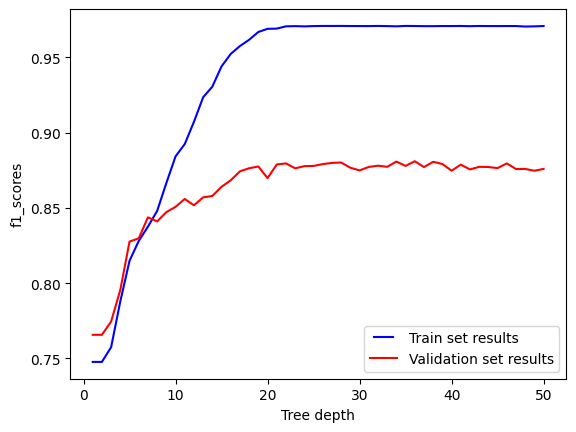

In [ ]:
### PARAMETER TUNING 
## Optimal_depth:
# (optimal_depth = 18, but increasing it can still improve the model)
max_depths = np.linspace(1, 50, 50, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
    rf = RandomForestClassifier(max_depth=int(max_depth), n_jobs=-1)
    rf.fit(X_train_cyclic, y_train)
    train_pred = rf.predict(X_train_cyclic)
    train_score = f1_score(y_train, train_pred, average = "weighted")
    train_results.append(train_score)
    y_pred = rf.predict(X_val_cyclic)
    test_score = f1_score(y_val, y_pred, average = "weighted")
    test_results.append(test_score)
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, "b", label="Train set results")
line2, = plt.plot(max_depths, test_results, "r", label="Validation set results")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("f1_scores")
plt.xlabel("Tree depth")
plt.show()

In [ ]:
optimal_depth = 20

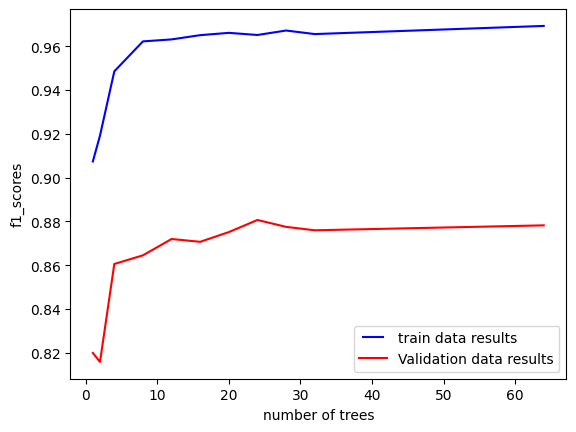

In [ ]:
## Optimal number of trees (n)
# (optimal_n = 20)
n_estimators = [1, 2, 4, 8, 12, 16, 20, 24, 28, 32, 64]
train_results = []
test_results = []
for estimator in n_estimators:
    rf = RandomForestClassifier(n_estimators = estimator, max_depth=optimal_depth, n_jobs=-1)
    rf.fit(X_train_cyclic, y_train)
    train_pred = rf.predict(X_train_cyclic)
    train_score = f1_score(y_train, train_pred, average = "weighted")
    train_results.append(train_score)
    y_pred = rf.predict(X_val_cyclic)
    test_score = f1_score(y_val, y_pred, average = "weighted")
    test_results.append(test_score)
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, "b", label="train data results")
line2, = plt.plot(n_estimators, test_results, "r", label="Validation data results")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("f1_scores")
plt.xlabel("number of trees")
plt.show()

In [ ]:
optimal_n = 22

In [ ]:
# model trained on cyclical variables
forest_cyclic = RandomForestClassifier(max_depth = optimal_depth, n_estimators = optimal_n, max_features = "sqrt", random_state=24) # add max_depth !!
forest_cyclic.fit(X_train_cyclic, y_train)

RandomForestClassifier(max_depth=20, n_estimators=22, random_state=24)

In [ ]:
### check performance on the TRAINING set for all models: ###
# predicted values :
pred_M1_cyclic = M1_cyclic.predict(X_train_cyclic)
pred_M1_acyclic = M1_acyclic.predict(X_train_acyclic)
pred_M2_cyc = M2_cyc.predict(X_train_cyclic)
pred_M2_acyc = M2_acyc.predict(X_train_acyclic)
pred_M2_cyc_B = M2_cyc_B.predict(X_train_cyclic)
pred_M2_acyc_B = M2_acyc_B.predict(X_train_acyclic)
pred_M2_pruned = pruned_M2_cyc.predict(X_train_cyclic)
forest_cyclic_pred = forest_cyclic.predict(X_train_cyclic)

# Calculate the scores:
M1_cyclic_score = f1_score(y_train, pred_M1_cyclic, average = "weighted")
M1_acyclic_score = f1_score(y_train, pred_M1_acyclic, average = "weighted")
M2_cyc_score = f1_score(y_train, pred_M2_cyc, average = "weighted")
M2_acyc_score = f1_score(y_train, pred_M2_acyc, average = "weighted")
M2_cyc_B_score = f1_score(y_train, pred_M2_cyc_B, average = "weighted")
M2_acyc_B_score = f1_score(y_train, pred_M2_acyc_B, average = "weighted")
score_M2_pruned = f1_score(y_train, pred_M2_pruned, average = "weighted")
f1_score_forest_cyclic = f1_score(y_train, forest_cyclic_pred, average = "weighted")

print("Score of Naive Bayes model (cyclic) on train set:", M1_cyclic_score)
print("Score of Naive Bayes model (acyclic) on train set:", M1_acyclic_score)
print("Score of Decision tree (cyclical) on train set:", M2_cyc_score)
print("SCore of Decision tree (acyclical) on train set:", M2_acyc_score)
print("Score of Decision tree (cyclical and balanced) on train set:", M2_cyc_B_score)
print("Score of Decision tree (acyclical and balanced) on train set:", M2_acyc_B_score)
print("Score of pruned Decision tree (cyclic) on train set:", score_M2_pruned)
print("Score of randomForest model (cyclic) on train set:", f1_score_forest_cyclic)

Score of Naive Bayes model (cyclic) on train set: 0.39607929270008285
Score of Naive Bayes model (acyclic) on train set: 0.357078223095443
Score of Decision tree (cyclical) on train set: 0.9714093666405819
SCore of Decision tree (acyclical) on train set: 0.9714093666405819
Score of Decision tree (cyclical and balanced) on train set: 0.9409466548901524
Score of Decision tree (acyclical and balanced) on train set: 0.9391139666562995
Score of pruned Decision tree (cyclic) on train set: 0.9036401184362852
Score of randomForest model (cyclic) on train set: 0.9668650512571503


In [ ]:
### check performance on the TEST set for all models: ###
# predicted values :
pred_M1_cyclic = M1_cyclic.predict(X_test_cyclic)
pred_M1_acyclic = M1_acyclic.predict(X_test_acyclic)
pred_M2_cyc = M2_cyc.predict(X_test_cyclic)
pred_M2_acyc = M2_acyc.predict(X_test_acyclic)
pred_M2_cyc_B = M2_cyc_B.predict(X_test_cyclic)
pred_M2_acyc_B = M2_acyc_B.predict(X_test_acyclic)
pred_M2_pruned = pruned_M2_cyc.predict(X_test_cyclic)
forest_cyclic_pred = forest_cyclic.predict(X_test_cyclic)

# Calculate the scores:
M1_cyclic_score = f1_score(y_test, pred_M1_cyclic, average = "weighted")
M1_acyclic_score = f1_score(y_test, pred_M1_acyclic, average = "weighted")
M2_cyc_score = f1_score(y_test, pred_M2_cyc, average = "weighted")
M2_acyc_score = f1_score(y_test, pred_M2_acyc, average = "weighted")
M2_cyc_B_score = f1_score(y_test, pred_M2_cyc_B, average = "weighted")
M2_acyc_B_score = f1_score(y_test, pred_M2_acyc_B, average = "weighted")
score_M2_pruned = f1_score(y_test, pred_M2_pruned, average = "weighted")
f1_score_forest_cyclic = f1_score(y_test, forest_cyclic_pred, average = "weighted")

print("Score of Naive Bayes model (cyclic) on test set:", M1_cyclic_score)
print("Score of Naive Bayes model (acyclic) on test set:", M1_acyclic_score)
print("Score of Decision tree (cyclical) on test set:", M2_cyc_score)
print("Score of Decision tree (acyclical) on test set:", M2_acyc_score)
print("Score of Decision tree (cyclical and balanced) on test set:", M2_cyc_B_score)
print("Score of Decision tree (acyclical and balanced) on test set:", M2_acyc_B_score)
print("Score of pruned Decision tree (cyclic) on test set:", score_M2_pruned)
print("Score of randomForest model (cyclic) on test set:", f1_score_forest_cyclic)

Score of Naive Bayes model (cyclic) on test set: 0.39052077330431634
Score of Naive Bayes model (acyclic) on test set: 0.375231806162916
Score of Decision tree (cyclical) on test set: 0.8156756600777292
SCore of Decision tree (acyclical) on test set: 0.8196033977281505
Score of Decision tree (cyclical and balanced) on test set: 0.7737567758241963
Score of Decision tree (acyclical and balanced) on test set: 0.7843117453484421
Score of pruned Decision tree (cyclic) on test set: 0.8304021002819878
Score of randomForest model (cyclic) on test set: 0.8627689232046416


**CONCLUSION:** RandomForestClassifier trained on the cyclical variables is the best model. 



In [ ]:
## (test) make single prediction for a new observation:
# class_labels:
class_labels_forest = forest_cyclic.classes_
feature_names = X_train_cyclic.columns.tolist()  # Get the list of (cyclical) feature names
x_new = X_test.iloc[3].drop(acyclic_time).values.reshape(1, -1) # extract x_new and convert to 2d array
x_new = pd.DataFrame(x_new, columns=feature_names) # convert x_new (array) to a data frame with the correct feature names
forest_cyclic.predict(x_new) # predicts category with the highest prob of occurance

array(['Transport road - Passenger car'], dtype=object)

In [ ]:
## (test) predict probabilities for new observation:
probas = forest_cyclic.predict_proba(x_new) # gives probability for all noise events
# Create a dictionary to map binary values to categories
prediction_mapping = dict(zip(range(len(class_labels_forest)), class_labels_forest))
prediction_mapping[2]
print("If there is a noise on (x_new) what are the probabilities of it being...")
for i in range(0, 6):
    category_label = prediction_mapping[i]
    percentage = round(probas[0][i]*100, 1)
    print(category_label, " :", percentage, "%")

If there is a noise on (x_new) what are the probabilities of it being...
Human voice - Shouting  : 0.6 %
Human voice - Singing  : 0.0 %
Music non-amplified  : 0.0 %
Nature elements - Wind  : 0.0 %
Transport road - Passenger car  : 99.4 %
Transport road - Siren  : 0.0 %


# **3. Encoders, decoders and regression models:**
### **3.1 Encoding WINDDIR, RAININ and DATE:**

In [ ]:
### WINDDIR ###
# Define the degree ranges and corresponding wind directions
ranges = [0, 23, 68, 113, 158, 203, 248, 293, 338, 361]
directions = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW', 'N']
to_degrees = [0, 45, 90, 135, 180, 225, 270, 315, 0]

# Encoder for WINDDIR: (note: we actually don't need this...)
def encode_WINDDIR(degrees):
    # Normalize degrees to range between 0 and 360
    degrees %= 360
    # Encode:
    if isinstance(degrees, int) : # for a single interger
        return pd.cut([degrees], bins=ranges, labels=directions, right=False, ordered=False)[0]
    else : # for a whole column
        return pd.cut(degrees, bins=ranges, labels=directions, right=False, ordered=False)
    
# Decoder for WINDDIR:
def decode_WINDDIR(direction):
    decoded_degree = to_degrees[directions.index(direction)]
    return decoded_degree

In [ ]:
# how to use:
encoded_directions = encode_WINDDIR(meteo_export41["LC_WINDDIR"]) # can take both columns and single values!
decoded_directions = encoded_directions.apply(decode_WINDDIR) # decode a column
decoded_single_value = decode_WINDDIR('N') # decode for single values

In [ ]:
### RAININ ###
intensities = [0.0, 0.1, 0.2, 0.5, 4, 9]
labels = ["No rain (0mm/hour)", "Very slight rain ( < 0.2mm/hour)", "Slight rain (0.2 - 0.5mm/hour)", "Moderate rain (0.5 - 4mm/hour)", "Heavy rain (4 - 8mm/hour)", "Very heavy rain ( > 8mm/hour)"]
    
# Decoder for RAININ:
def decode_RAININ(label):
    intensity = intensities[labels.index(label)]
    return intensity

In [ ]:
# how to use:
decoded_single_value = decode_RAININ("Very slight rain ( < 0.2mm/hour)") # decode for single values
decoded_single_value

0.1

### **3.12 Regression for Radiation (LC_RAD60) :**

In [ ]:
average_meteo['month'] = average_meteo['DATEUTC'].dt.month
average_meteo['day'] = average_meteo['DATEUTC'].dt.day
average_meteo['hour'] = average_meteo['DATEUTC'].dt.hour

Y = average_meteo["LC_RAD60"].values.reshape(-1, 1)
X = average_meteo[['month', 'LC_HUMIDITY', 'AV_TEMP','hour']]
X['hour_sin'] = np.sin(2 * np.pi * X['hour'] / 24)
X['hour_cos'] = np.cos(2 * np.pi * X['hour'] / 24)
X = X.drop('hour', axis=1)
X = sm.add_constant(X)
est_rediation = sm.OLS(Y, X).fit()

print(est_rediation.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.699
Model:                            OLS   Adj. R-squared:                  0.699
Method:                 Least Squares   F-statistic:                 2.443e+04
Date:                Sun, 04 Jun 2023   Prob (F-statistic):               0.00
Time:                        17:42:08   Log-Likelihood:            -2.9627e+05
No. Observations:               52560   AIC:                         5.925e+05
Df Residuals:                   52554   BIC:                         5.926e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         260.2809      2.331    111.673      

<ipython-input-12-23df70a93b3b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['hour_sin'] = np.sin(2 * np.pi * X['hour'] / 24)
<ipython-input-12-23df70a93b3b>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['hour_cos'] = np.cos(2 * np.pi * X['hour'] / 24)


### **3.13 Regression for Dew Temperature (LC_DWPTEMP) :**

In [ ]:
Y = average_meteo["LC_DWPTEMP"]
X = average_meteo['AV_TEMP']
X = sm.add_constant(X)
est_dwtemp = sm.OLS(Y, X).fit()
print(est_dwtemp.summary())

                            OLS Regression Results                            
Dep. Variable:             LC_DWPTEMP   R-squared:                       0.658
Model:                            OLS   Adj. R-squared:                  0.658
Method:                 Least Squares   F-statistic:                 1.013e+05
Date:                Sun, 04 Jun 2023   Prob (F-statistic):               0.00
Time:                        17:47:31   Log-Likelihood:            -1.3502e+05
No. Observations:               52560   AIC:                         2.700e+05
Df Residuals:                   52558   BIC:                         2.701e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4000      0.027     14.627      0.0

# **4. Statistical Analysis (for the report)**

In [ ]:
#traffic descriptive statistic
df = pd.DataFrame(traffic)
print(df.describe())

             heavy          car         bike   pedestrian
count  6700.000000  6700.000000  6700.000000  6700.000000
mean      4.288612    24.591081    46.420345    33.518763
std      11.510613    55.756232   110.389379    59.100942
min       0.000000     0.000000     0.000000     0.000000
25%       0.000000     0.000000     0.000000     0.000000
50%       0.000000     0.000000     0.000000     0.000000
75%       1.290323    15.639122    36.350975    55.543673
max      92.665726   720.000000  1019.937041  1036.403191


In [ ]:
# descriptive statistics of Export 41
print(export41)

                  description                   DATEUTC  certainty  \
0          MP08bis - Vrijthof 2022-04-20 12:30:00+02:00      100.0   
1          MP08bis - Vrijthof 2022-04-24 21:10:00+02:00      100.0   
2          MP08bis - Vrijthof 2022-04-24 21:10:00+02:00      100.0   
3          MP08bis - Vrijthof 2022-05-09 13:20:00+02:00      100.0   
4          MP08bis - Vrijthof 2022-05-10 03:40:00+02:00      100.0   
...                       ...                       ...        ...   
56438  MP 07: Naamsestraat 81 2022-12-31 12:20:00+01:00       99.0   
56439  MP 07: Naamsestraat 81 2022-12-31 12:30:00+01:00      100.0   
56440  MP 07: Naamsestraat 81 2022-12-31 15:20:00+01:00       87.0   
56441  MP 07: Naamsestraat 81 2022-12-31 17:10:00+01:00      100.0   
56442  MP 07: Naamsestraat 81 2022-12-31 20:00:00+01:00       77.0   

                          noise_event  
0      Transport road - Passenger car  
1              Nature elements - Wind  
2              Nature elements - Wind  

In [ ]:
#descriptive clean meteo
print(average_meteo.describe())

        LC_HUMIDITY    LC_DWPTEMP        LC_RAD     LC_RAININ  LC_DAILYRAIN  \
count  52560.000000  52560.000000  52560.000000  52560.000000  52560.000000   
mean      75.145535      7.918712     74.646959      0.000098      0.001079   
std       17.934663      5.402531    125.121398      0.000812      0.003451   
min       15.204082     -8.540417      0.000000      0.000000      0.000000   
25%       62.872340      4.004607      0.081633      0.000000      0.000000   
50%       80.020204      8.512042      0.255319      0.000000      0.000000   
75%       90.159091     12.037296     97.047207      0.000000      0.000061   
max       98.276596     22.140833    647.369565      0.063064      0.044511   

           LC_RAD60       AV_TEMP    LC_WINDDIR  LC_WINDSPEED         month  \
count  52560.000000  52560.000000  52560.000000  52560.000000  52560.000000   
mean      74.683993     12.769799     -2.414636      0.205908      6.526826   
std      123.780098      7.445087     25.853657    

In [ ]:
## descriptive of the merged dataset
print(merged)

                       DATEUTC  LC_HUMIDITY  LC_DWPTEMP      LC_RAD  \
0    2022-01-07 17:00:00+01:00    92.250000    1.642917    0.125000   
1    2022-01-09 22:00:00+01:00    93.954545    0.514545    0.090909   
2    2022-01-10 11:00:00+01:00    97.723404   -0.529574   43.702128   
3    2022-01-11 09:00:00+01:00    92.553191   -0.800000    3.531915   
4    2022-01-12 07:00:00+01:00    90.063830    0.456809    0.085106   
...                        ...          ...         ...         ...   
7118 2022-10-07 15:00:00+02:00    54.346939    9.376327  283.489796   
7119 2022-10-07 15:00:00+02:00    54.346939    9.376327  283.489796   
7120 2022-10-07 15:00:00+02:00    54.346939    9.376327  283.489796   
7121 2022-10-07 15:00:00+02:00    54.346939    9.376327  283.489796   
7122 2022-10-07 15:00:00+02:00    54.346939    9.376327  283.489796   

      LC_RAININ  LC_DAILYRAIN    LC_RAD60    AV_TEMP  LC_WINDDIR  \
0      0.000021      0.004667    8.645833   2.753157  -10.571429   
1      0.00

In [ ]:
#see what noise_encoded variable (the DV) includes 
print(merged['noise_event'])

0       Transport road - Passenger car
1       Transport road - Passenger car
2               Human voice - Shouting
3       Transport road - Passenger car
4               Human voice - Shouting
                     ...              
7118            Human voice - Shouting
7119            Transport road - Siren
7120            Transport road - Siren
7121            Transport road - Siren
7122            Transport road - Siren
Name: noise_event, Length: 7123, dtype: object


In [ ]:
#encode DV(noise event into 6 NUMERIC classes)
noise_encoded = LabelEncoder()
merged['NoiseEventEncoded'] = noise_encoded.fit_transform(merged['noise_event'])
print(merged.NoiseEventEncoded)

0       4
1       4
2       0
3       4
4       0
       ..
7118    0
7119    5
7120    5
7121    5
7122    5
Name: NoiseEventEncoded, Length: 7123, dtype: int64


In [ ]:
# Count the values in the 'noise_event' column to compare them to NoiseEventEncoded
noise_event_counts = merged['noise_event'].value_counts()
print(noise_event_counts)

Transport road - Passenger car    5902
Human voice - Shouting             772
Transport road - Siren             274
Human voice - Singing              142
Music non-amplified                 19
Nature elements - Wind              14
Name: noise_event, dtype: int64


In [ ]:
# Count the values in the 'NoiseEventEncoded' column to compare them to noise_event
NoiseEventEncoded_counts = merged['NoiseEventEncoded'].value_counts()
print(NoiseEventEncoded_counts)

4    5902
0     772
5     274
1     142
2      19
3      14
Name: NoiseEventEncoded, dtype: int64


In [ ]:
# create a dummy using the DV
# binary coding/ dummy traffic
df = pd.DataFrame(merged)

classes_zero = ['Human voice - Shouting', 'Human voice - Singing', 'Nature elements - Wind', 'Music non-amplified']
df['Dummytraffic'] = np.where(df['noise_event'].isin(classes_zero), 0, 1)
comparison = pd.concat([df['noise_event'], df['Dummytraffic']], axis=1)

print(comparison)

                         noise_event  Dummytraffic
0     Transport road - Passenger car             1
1     Transport road - Passenger car             1
2             Human voice - Shouting             0
3     Transport road - Passenger car             1
4             Human voice - Shouting             0
...                              ...           ...
7118          Human voice - Shouting             0
7119          Transport road - Siren             1
7120          Transport road - Siren             1
7121          Transport road - Siren             1
7122          Transport road - Siren             1

[7123 rows x 2 columns]


In [ ]:
##logistic regression - traffic
y = merged['Dummytraffic']
X = merged[['LC_WINDSPEED', 'LC_HUMIDITY', 'AV_TEMP', 'LC_RAININ', 'academic_calender', 'weekend']]

X = sm.add_constant(X)

model = sm.Logit(y, X)
result = model.fit()

print(result.summary())

Optimization terminated successfully.
         Current function value: 0.369430
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:           Dummytraffic   No. Observations:                 7123
Model:                          Logit   Df Residuals:                     7116
Method:                           MLE   Df Model:                            6
Date:                Sun, 04 Jun 2023   Pseudo R-squ.:                 0.05747
Time:                        12:31:19   Log-Likelihood:                -2631.4
converged:                       True   LL-Null:                       -2791.9
Covariance Type:            nonrobust   LLR p-value:                 2.702e-66
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.1355      0.273     -0.496      0.620      -0.671       0.400
LC_WINDS

In [ ]:
# # create a second dummy using the DV
# binary coding/ dummy human-made voice
df = pd.DataFrame(merged)
classes_zero = ['Transport road - Passenger car', 'Transport - Siren', 'Nature elements - Wind']
df['Dummyhuman'] = np.where(df['noise_event'].isin(classes_zero), 0, 1)
comparison = pd.concat([df['noise_event'], df['Dummyhuman']], axis=1)

print(comparison)

                         noise_event  Dummyhuman
0     Transport road - Passenger car           0
1     Transport road - Passenger car           0
2             Human voice - Shouting           1
3     Transport road - Passenger car           0
4             Human voice - Shouting           1
...                              ...         ...
7118          Human voice - Shouting           1
7119          Transport road - Siren           1
7120          Transport road - Siren           1
7121          Transport road - Siren           1
7122          Transport road - Siren           1

[7123 rows x 2 columns]


In [ ]:
##logistic regression - human noise
y = merged['Dummyhuman']
X = merged[['LC_WINDSPEED', 'LC_HUMIDITY', 'AV_TEMP', 'LC_RAININ', 'academic_calender', 'weekend']]

X = sm.add_constant(X)

model = sm.Logit(y, X)
result = model.fit()

print(result.summary())

Optimization terminated successfully.
         Current function value: 0.432700
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:             Dummyhuman   No. Observations:                 7123
Model:                          Logit   Df Residuals:                     7116
Method:                           MLE   Df Model:                            6
Date:                Sun, 04 Jun 2023   Pseudo R-squ.:                 0.04904
Time:                        12:31:24   Log-Likelihood:                -3082.1
converged:                       True   LL-Null:                       -3241.1
Covariance Type:            nonrobust   LLR p-value:                 1.193e-65
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.5757      0.248      2.324      0.020       0.090       1.061
LC_WINDS

In [ ]:
# round the traffic dataset value into interger


variable_to_recode = ['heavy', 'car', 'bike', 'pedestrian']
merged[variable_to_recode] = merged[variable_to_recode].apply(lambda x: x.astype(int))

print(merged)

                       DATEUTC  LC_HUMIDITY  LC_DWPTEMP      LC_RAD  \
0    2022-01-07 17:00:00+01:00    92.250000    1.642917    0.125000   
1    2022-01-09 22:00:00+01:00    93.954545    0.514545    0.090909   
2    2022-01-10 11:00:00+01:00    97.723404   -0.529574   43.702128   
3    2022-01-11 09:00:00+01:00    92.553191   -0.800000    3.531915   
4    2022-01-12 07:00:00+01:00    90.063830    0.456809    0.085106   
...                        ...          ...         ...         ...   
7118 2022-10-07 15:00:00+02:00    54.346939    9.376327  283.489796   
7119 2022-10-07 15:00:00+02:00    54.346939    9.376327  283.489796   
7120 2022-10-07 15:00:00+02:00    54.346939    9.376327  283.489796   
7121 2022-10-07 15:00:00+02:00    54.346939    9.376327  283.489796   
7122 2022-10-07 15:00:00+02:00    54.346939    9.376327  283.489796   

      LC_RAININ  LC_DAILYRAIN    LC_RAD60    AV_TEMP  LC_WINDDIR  \
0      0.000021      0.004667    8.645833   2.753157  -10.571429   
1      0.00

In [ ]:
#logistic trafficnoise & traffic
y = merged['Dummytraffic']
X = merged[['heavy', 'car', 'pedestrian', 'bike']] 

X = sm.add_constant(X)

model = sm.Logit(y, X)
result = model.fit()

print(result.summary())

Optimization terminated successfully.
         Current function value: 0.389978
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:           Dummytraffic   No. Observations:                 7123
Model:                          Logit   Df Residuals:                     7118
Method:                           MLE   Df Model:                            4
Date:                Sun, 04 Jun 2023   Pseudo R-squ.:                0.005046
Time:                        12:31:30   Log-Likelihood:                -2777.8
converged:                       True   LL-Null:                       -2791.9
Covariance Type:            nonrobust   LLR p-value:                 1.150e-05
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7702      0.041     42.997      0.000       1.690       1.851
heavy         -0.0012      0.

In [ ]:
#crosstab noise event & weekend

cross_tab = pd.crosstab(merged['weekend'], merged['noise_event'])
row_percentages = cross_tab.div(cross_tab.sum(axis=1), axis=0) * 100
column_percentages = cross_tab.div(cross_tab.sum(axis=0), axis=1) * 100

# Print the cross-tabulation table with row and column percentages
print("Cross-tabulation table:")
print(cross_tab)
print("\nRow percentages:")
print(row_percentages)
print("\nColumn percentages:")
print(column_percentages)

Cross-tabulation table:
noise_event  Human voice - Shouting  Human voice - Singing  \
weekend                                                      
0                               664                    132   
1                               108                     10   

noise_event  Music non-amplified  Nature elements - Wind  \
weekend                                                    
0                             16                      12   
1                              3                       2   

noise_event  Transport road - Passenger car  Transport road - Siren  
weekend                                                              
0                                      5068                     227  
1                                       834                      47  

Row percentages:
noise_event  Human voice - Shouting  Human voice - Singing  \
weekend                                                      
0                         10.851446               2.157215   
1 